In [29]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pickle
from pathlib import Path

import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(tf.__version__)

2.3.0


In [3]:
cces = pd.read_csv('data/cces_df.csv', index_col=0)
cces_all = pd.read_csv('data/cces_all_df.csv', index_col=0)
cces_weighted = pd.read_csv('data/cces_weighted_df.csv', index_col=0)

In [4]:
cces

,abortion,eth,male,age,educ,repvote,region,state
1,1,White,-0.5,60-69,4-Year College,0.504080,North Central,WI
2,1,White,-0.5,60-69,HS,0.427158,Northeast,NJ
3,0,White,-0.5,40-49,HS,0.506188,South,FL
4,1,White,0.5,70+,Some college,0.506188,South,FL
5,0,White,-0.5,50-59,Some college,0.409799,North Central,IL
...,...,...,...,...,...,...,...,...
4996,0,White,0.5,50-59,4-Year College,0.338718,West,CA
4997,0,White,0.5,18-29,Some college,0.518900,West,AZ
4998,1,White,0.5,50-59,HS,0.473167,West,CO
4999,1,White,-0.5,50-59,HS,0.506188,South,FL


## Transform data

In [5]:
# Fills in the dictionary so that we know which index corresponds to what state / eth / edu etc.

data_to_idx = {}
list_of_states_and_votes = []
list_of_states = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces_all)+1):
    tup = (cces_all.loc[i,'state'], cces_all.loc[i,'repvote'])
    if cces_all.loc[i,'state'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'state']] = state
        state += 1
    if tup not in list_of_states_and_votes:
        list_of_states_and_votes.append(tup)
    if cces_all.loc[i,'age'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'age']] = age
        age += 1
    if cces_all.loc[i,'eth'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'eth']] = eth
        eth += 1
    if cces_all.loc[i,'educ'] not in data_to_idx:
        data_to_idx[cces_all.loc[i,'educ']] = educ
        educ += 1
list_of_states_and_votes.sort(key=lambda x:x[1])
for tup in list_of_states_and_votes:
    list_of_states.append(tup[0])

In [6]:
# Create new representation of data that contains only 0 and 1

def transform_raw(cces, data_to_idx, i, 
                  state=0, age=50, eth=56, educ=60,
                  male_eth=65, educ_age=73, educ_eth=103):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces.loc[i,'eth']]
    age_idx = data_to_idx[cces.loc[i,'age']]
    educ_idx = data_to_idx[cces.loc[i,'educ']]
    x_i[data_to_idx[cces.loc[i,'state']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces.loc[i,'region'] == 'South')
    x_i[125] = int(cces.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces.loc[i,'region'] == 'West')
    x_i[127] = cces.loc[i,'repvote']
    
    return x_i

x = []
y = []
for i in range(1, len(cces)+1):
    x_i = transform_raw(cces, data_to_idx, i)
    
    x.append(x_i)
    y.append(cces.loc[i,'abortion'])

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

## Variational Inference

In [7]:
# model = models.VI_KLqp(dataset='survey', v_fam='flow')
# model.x = x
# model.y = y
# model.train(lr=0.003)

In [8]:
# model = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Hamiltonian Score Climbing

In [9]:
# model = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.001)

In [10]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

In [11]:
# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

In [12]:
# # MSC
# model = models.VI_KLpq(v_fam='gaussian', space='theta', dataset='survey', hmc_e=0.03, hmc_L=33, chains=1)
# model.x = x
# model.y = y
# model.train(lr=0.01)

## Real MSC

In [13]:
# #MSC, i-SIR

# model = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, chains=2, cis=10, eps=0.5, alpha=0.95, rejuvenation=True)
# model.x = x
# model.y = y
# model.train(lr=0.01, epochs=int(1e4))

## Evaluations

In [14]:
poststrat_df = pd.read_csv('data/poststrat_df.csv')
statelevel_predictors_df = pd.read_csv('data/statelevel_predictors.csv', index_col=0)
poststrat_df = poststrat_df.merge(statelevel_predictors_df, how='left', on='state')
mrp_states_df = pd.read_csv('data/mrp_states.csv')
poststrat_df.head()

,state,eth,male,age,educ,n,repvote,region
0,AL,White,-0.5,18-29,No HS,23948,0.643741,South
1,AL,White,-0.5,18-29,HS,59378,0.643741,South
2,AL,White,-0.5,18-29,Some college,104855,0.643741,South
3,AL,White,-0.5,18-29,4-Year College,37066,0.643741,South
4,AL,White,-0.5,18-29,Post-grad,9378,0.643741,South


In [15]:
# Transform raw data into 0-1 vectors:
x_poststrat = []
for i in range(len(poststrat_df)):
    x_i = transform_raw(poststrat_df, data_to_idx, i)
    x_poststrat.append(x_i)
x_poststrat = np.array(x_poststrat, dtype='float32')

In [16]:
def estimate_vi_model_rate(x_poststrat, data_to_idx, model):
    model.x = x_poststrat
    splitted_x = tf.split(model.x, [123, 5], axis=1)
    alpha = model.q.sample(10000)
    term1 = tf.matmul(splitted_x[0], tf.transpose(alpha))
    term2 = model.gamma_0
    term3 = tf.matmul(splitted_x[1], tf.reshape(model.gamma, (5, 1)))
    post_pred_mat = tf.math.sigmoid(tf.squeeze(term1 + term2 + term3))

    return post_pred_mat

def get_se_bernoulli(p, n):
    return np.sqrt(p*(1-p)/n)

In [17]:
# 5,000-person unadjusted sample estimate:
print('mean', np.mean(cces['abortion']))
print('std', get_se_bernoulli(np.mean(cces['abortion']), len(cces)))

mean 0.4314
std 0.007004199311841433


In [18]:
# 60,000-person unadjusted sample estimate:
print('mean', np.mean(cces_all['abortion']))
print('std', get_se_bernoulli(np.mean(cces_all['abortion']), len(cces_all)))

mean 0.4341581675305133
std 0.002026677342749567


In [19]:
# # load model VI KLqp Gaussian
# path = 'results/survey/vi_klqp_gaussian/2021-10-13-172522/'
# model_qp = models.VI_KLqp(dataset='survey', v_fam='gaussian')
# model_qp.x = x
# model_qp.y = y
# model_qp.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp.phi_m = np.genfromtxt(path + 'phi_m.csv', dtype='float32')[-1,:]
# model_qp.phi_s = np.genfromtxt(path + 'phi_s.csv', dtype='float32')[-1,:]
# model_qp.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp.q = tfd.MultivariateNormalDiag(
#               loc=model_qp.phi_m, 
#               scale_diag=model_qp.phi_s)

In [20]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [43]:
# load model VI KLpq Gaussian - HSC
path = Path('results/survey/vi_klpq_N0_warped_gaussian/2022-04-18-102854')
model_pq = models.VI_KLpq(v_fam='gaussian', space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, chains=1)
model_pq.x = x
model_pq.y = y
model_pq.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
model_pq.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
model_pq.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
model_pq.q = tfd.MultivariateNormalDiag(
    loc=model_pq.phi_m, 
    scale_diag=model_pq.phi_s)

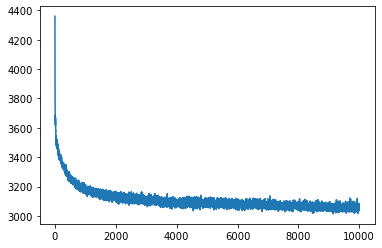

In [44]:
losses = np.genfromtxt(path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [45]:
# load model VI KLpq Gaussian - MSC
path = Path('results/survey/vi_klpq_N10_eps_gaussian/2022-04-14-180124')
model_pq_ex2_eps = models.VI_KLpq(v_fam='gaussian', space='eps', dataset='survey', hmc_e=0.05, hmc_L=20, cis=10, chains=1)
model_pq_ex2_eps.x = x
model_pq_ex2_eps.y = y
model_pq_ex2_eps.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_eps.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_eps.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_eps.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_eps.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_eps.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_eps.phi_m, 
    scale_diag=model_pq_ex2_eps.phi_s)

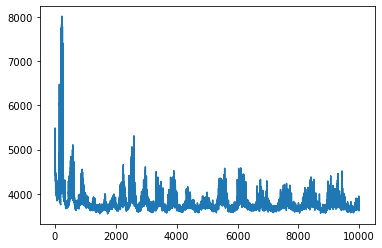

In [46]:
losses = np.genfromtxt(path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [47]:
# load model VI KLpq Gaussian - MSC
path = Path('results/survey/vi_klpq_N10_warped_gaussian/2022-04-14-183205')
model_pq_ex2_warp = models.VI_KLpq(v_fam='gaussian', space='warped', dataset='survey', hmc_e=0.05, hmc_L=20, cis=10, chains=1)
model_pq_ex2_warp.x = x
model_pq_ex2_warp.y = y
model_pq_ex2_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
model_pq_ex2_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
    loc=model_pq_ex2_warp.phi_m, 
    scale_diag=model_pq_ex2_warp.phi_s)

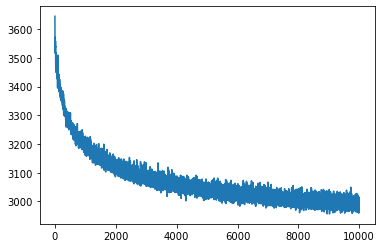

In [48]:
losses = np.genfromtxt(path / 'losses.csv', dtype='float32')
plt.plot(list(range(len(losses))), losses)

In [49]:
# # load model VI KLqp Flow
# path = 'results/survey/vi_klqp_flow/2021-09-03-223300/'
# model_qp_flow = models.VI_KLqp(v_fam='flow', dataset='survey')
# model_qp_flow.x = x
# model_qp_flow.y = y
# model_qp_flow.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_qp_flow.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_qp_flow.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_qp_flow.load_model(path + 'flow_model/model')

In [50]:
# losses = -np.genfromtxt(path + 'elbo.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [51]:
# # load model VI KLpq Flow
path = Path('results/survey/vi_klpq_warped_flow/2022-04-14-151501')
# model_pq_flow = models.VI_KLpq(v_fam='flow', space='warped', dataset='survey', hmc_e=0.03, hmc_L=33, chains=64)
# model_pq_flow.x = x
# model_pq_flow.y = y
# model_pq_flow.gamma_0 = np.genfromtxt(path + 'gamma_0.csv', dtype='float32')[-1]
# model_pq_flow.gamma = np.genfromtxt(path + 'gamma.csv', dtype='float32')[-1,:]
# model_pq_flow.sigma = np.genfromtxt(path + 'sigma.csv', dtype='float32')[-1,:]
# model_pq_flow.load_model(path + 'flow_model/model')

In [52]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [53]:
# load model VI KLpq Gaussian - MSC
path = Path('results/survey/vi_klpq_N10_eps_flow/2022-04-14-183205')
# model_pq_ex2_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_warp.x = x
# model_pq_ex2_warp.y = y
# model_pq_ex2_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_warp.phi_m, 
#     scale_diag=model_pq_ex2_warp.phi_s)

In [54]:
# losses = np.genfromtxt(path + 'losses.csv', dtype='float32')
# plt.plot(list(range(len(losses))), losses)

In [55]:
# load model VI KLpq Gaussian - MSC
path = Path('results/survey/vi_klpq_N10_warped_flow/2022-04-14-183205')
# model_pq_ex2_warp = models.VI_KLpq(v_fam='flow', space='eps', dataset='survey', hmc_e=0.03, hmc_L=33, cis=10, chains=1)
# model_pq_ex2_warp.x = x
# model_pq_ex2_warp.y = y
# model_pq_ex2_warp.gamma_0 = np.genfromtxt(path / 'gamma_0.csv', dtype='float32')[-1]
# model_pq_ex2_warp.gamma = np.genfromtxt(path / 'gamma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_m = np.genfromtxt(path / 'phi_m.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.phi_s = np.genfromtxt(path / 'phi_s.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.sigma = np.genfromtxt(path / 'sigma.csv', dtype='float32')[-1,:]
# model_pq_ex2_warp.q = tfd.MultivariateNormalDiag(
#     loc=model_pq_ex2_warp.phi_m, 
#     scale_diag=model_pq_ex2_warp.phi_s)

In [56]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [57]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
estimate = np.dot(np.array([poststrat_df['n']]), 
                  np.array(post_pred_mat_pq)) / sum(poststrat_df['n'])
print('mean', np.mean(estimate))
print('std', np.std(estimate))

mean 0.43503890427026737
std 0.02329209157682803


In [58]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
estimate = np.dot(np.array([poststrat_df['n']]), 
                  np.array(post_pred_mat_pq_msc)) / sum(poststrat_df['n'])
print('mean', np.mean(estimate))
print('std', np.std(estimate))

mean 0.417239348588358
std 0.12917105912211946


In [59]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_qp_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

In [62]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# estimate = np.dot(np.array([poststrat_df['n']]), 
#                   np.array(post_pred_mat_pq_flow)) / sum(poststrat_df['n'])
# print('mean', np.mean(estimate))
# print('std', np.std(estimate))

Compare parameters under different number of VI samples

In [ ]:
path = 'results/survey/vi_klpq_gaussian/2021-09-01-162133/'
gamma = np.genfromtxt(path + 'gamma.csv')
plt.plot(gamma[:,0], label='gamma_1')
plt.plot(gamma[:,1], label='gamma_2')
plt.plot(gamma[:,2], label='gamma_3')
plt.plot(gamma[:,3], label='gamma_4')
plt.plot(gamma[:,4], label='gamma_5')
plt.show()

In [ ]:
path = 'results/survey/vi_klpq_gaussian/2021-07-02-164958/'
gamma_1samp = np.genfromtxt(path + 'gamma.csv')
plt.plot(gamma_1samp[:,0], label='gamma_1')
plt.plot(gamma_1samp[:,1], label='gamma_2')
plt.plot(gamma_1samp[:,2], label='gamma_3')
plt.plot(gamma_1samp[:,3], label='gamma_4')
plt.plot(gamma_1samp[:,4], label='gamma_5')
plt.show()

### By-state predictions

By state

In [63]:
# post_pred_mat_qp = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp)
# state_means_qp = []
# state_stds_qp = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp.append(np.mean(estimate))
#     state_stds_qp.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp = np.array(state_means_qp)
# state_stds_qp = np.array(state_stds_qp)

In [64]:
post_pred_mat_pq = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq)
state_means_pq = []
state_stds_pq = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq.append(np.mean(estimate))
    state_stds_pq.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq = np.array(state_means_pq)
state_stds_pq = np.array(state_stds_pq)

HI
mean 0.3575572917959262
std 0.04434721851767331
CA
mean 0.3781119365367206
std 0.02961691745187514
VT
mean 0.39312338548694115
std 0.046924462081802565
MA
mean 0.34847849905984696
std 0.03631081576506501
MD
mean 0.3461167212799938
std 0.037733434049210854
NY
mean 0.35090184646496997
std 0.031482743211991474
IL
mean 0.40111505920054225
std 0.0344765482836129
WA
mean 0.37948806271714314
std 0.037397993951803446
RI
mean 0.3667632184786766
std 0.04560492049659994
NJ
mean 0.36868170679492623
std 0.035239353267014606
CT
mean 0.3578530928952358
std 0.0420190033088445
OR
mean 0.38845659673444005
std 0.040911931335066556
DE
mean 0.44871270197301066
std 0.04542327218320378
NM
mean 0.40177725006528714
std 0.04339665790791019
VA
mean 0.4290694596297216
std 0.037133891512301134
CO
mean 0.4107800050020424
std 0.041442958697847386
ME
mean 0.43216193274288417
std 0.04702904574562479
NV
mean 0.39446566323348536
std 0.03984719011366121
MN
mean 0.4295773902629367
std 0.0424342554227701
NH
mean 0.42384

In [71]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_eps)
state_means_pq_ex2_eps = []
state_stds_pq_ex2_eps = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_eps.append(np.mean(estimate))
    state_stds_pq_ex2_eps.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_msc = np.array(state_means_pq_ex2_eps)
state_stds_pq_ex2_eps = np.array(state_stds_pq_ex2_eps)

HI
mean 0.37187054540623876
std 0.16158829057714588
CA
mean 0.38476836311176055
std 0.12409322433247645
VT
mean 0.49294634526942144
std 0.1931266523503676
MA
mean 0.3706661226721275
std 0.1552336103774304
MD
mean 0.35994280100915194
std 0.1388020362561552
NY
mean 0.37444031867838257
std 0.13699125976359003
IL
mean 0.4038455812887228
std 0.14481086668010967
WA
mean 0.3777076571702574
std 0.153765861670408
RI
mean 0.37150505386705956
std 0.16809772742693732
NJ
mean 0.3826996066684261
std 0.14034988984917024
CT
mean 0.3642175344157086
std 0.15539678384491462
OR
mean 0.37858954027967395
std 0.16697878546075856
DE
mean 0.46096070790367155
std 0.16240493197207165
NM
mean 0.39060653264010714
std 0.14034923572943775
VA
mean 0.4192881270160356
std 0.1454890690552409
CO
mean 0.4057424159717915
std 0.15577599449069926
ME
mean 0.4299421109594482
std 0.187236612292946
NV
mean 0.37373731286041795
std 0.14263387617247275
MN
mean 0.4120575401329638
std 0.17180013098058677
NH
mean 0.41057789470836553
s

In [77]:
post_pred_mat_pq_msc = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_ex2_warp)
state_means_pq_ex2_warp = []
state_stds_pq_ex2_warp = []
for state in list_of_states:
    is_state = np.array([poststrat_df['state'] == state])
    estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
                      np.array(post_pred_mat_pq_msc)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
    state_means_pq_ex2_warp.append(np.mean(estimate))
    state_stds_pq_ex2_warp.append(np.std(estimate))
    print(state)
    print('mean', np.mean(estimate))
    print('std', np.std(estimate))
state_means_pq_ex2_warp = np.array(state_means_pq_ex2_warp)
state_stds_pq_ex2_warp = np.array(state_stds_pq_ex2_warp)

HI
mean 0.3549756328516662
std 0.03603487319228142
CA
mean 0.3788684008388238
std 0.023857064714696605
VT
mean 0.3913920431301104
std 0.0384009354858406
MA
mean 0.34870525851176015
std 0.029772866399440483
MD
mean 0.3566321697048983
std 0.031005231258987992
NY
mean 0.35348032511823474
std 0.02541684532970774
IL
mean 0.3987318826674687
std 0.028021470125096287
WA
mean 0.3812164473232671
std 0.031758737266218424
RI
mean 0.36542713318230047
std 0.03695706091600086
NJ
mean 0.3660696118706175
std 0.030427579315537225
CT
mean 0.36226015315878646
std 0.03476227592420865
OR
mean 0.3916189970794398
std 0.03420215512227709
DE
mean 0.4508914611242898
std 0.037082296418708985
NM
mean 0.4001945083817636
std 0.03538563885916172
VA
mean 0.4320920499351684
std 0.0301033703480697
CO
mean 0.4114748907076001
std 0.03382399453185022
ME
mean 0.4278042824935797
std 0.03825538955696034
NV
mean 0.39034557887476173
std 0.03354550231950968
MN
mean 0.433183699813595
std 0.03621991989294046
NH
mean 0.418157636309

In [ ]:
# post_pred_mat_qp_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_qp_flow)
# state_means_qp_flow = []
# state_stds_qp_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_qp_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_qp_flow.append(np.mean(estimate))
#     state_stds_qp_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_qp_flow = np.array(state_means_qp_flow)
# state_stds_qp_flow = np.array(state_stds_qp_flow)

In [67]:
pass
# post_pred_mat_pq_flow = estimate_vi_model_rate(x_poststrat, data_to_idx, model_pq_flow)
# state_means_pq_flow = []
# state_stds_pq_flow = []
# for state in list_of_states:
#     is_state = np.array([poststrat_df['state'] == state])
#     estimate = np.dot(np.multiply(np.array([poststrat_df['n']]), is_state), 
#                       np.array(post_pred_mat_pq_flow)) / np.sum(np.multiply(np.array([poststrat_df['n']]), is_state))
#     state_means_pq_flow.append(np.mean(estimate))
#     state_stds_pq_flow.append(np.std(estimate))
#     print(state)
#     print('mean', np.mean(estimate))
#     print('std', np.std(estimate))
# state_means_pq_flow = np.array(state_means_pq_flow)
# state_stds_pq_flow = np.array(state_stds_pq_flow)

In [68]:
state_means_unadj_5000 = []
state_stds_unadj_5000 = []
for state in list_of_states:
    is_state = np.array([cces['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces['abortion']]), is_state))/n
    state_means_unadj_5000.append(mean)
    state_stds_unadj_5000.append(get_se_bernoulli(mean, n))
state_means_unadj_5000 = np.array(state_means_unadj_5000)
state_stds_unadj_5000 = np.array(state_stds_unadj_5000)

In [69]:
state_means_unadj_60000 = []
state_stds_unadj_60000 = []
for state in list_of_states:
    is_state = np.array([cces_all['state'] == state])
    n = np.sum(is_state)
    mean = np.sum(np.multiply(np.array([cces_all['abortion']]), is_state))/n
    state_means_unadj_60000.append(mean)
    state_stds_unadj_60000.append(get_se_bernoulli(mean, n))
state_means_unadj_60000 = np.array(state_means_unadj_60000)
state_stds_unadj_60000 = np.array(state_stds_unadj_60000)

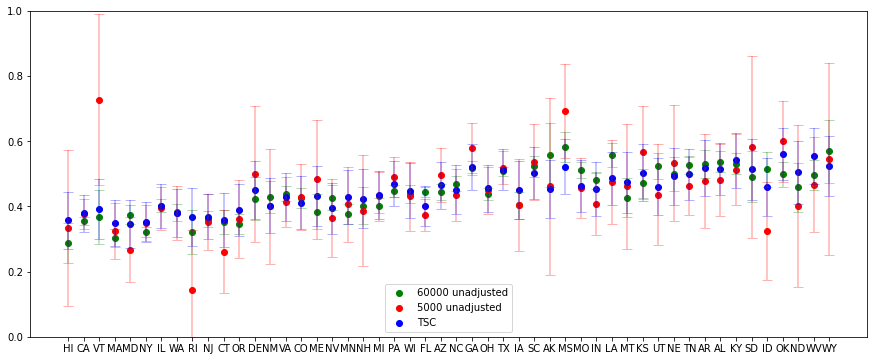

In [81]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_unadj_5000, color='r', label='5000 unadjusted')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')


plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_unadj_5000, 
             yerr=1.96*state_stds_unadj_5000, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)

plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_unadj.png')
plt.show()

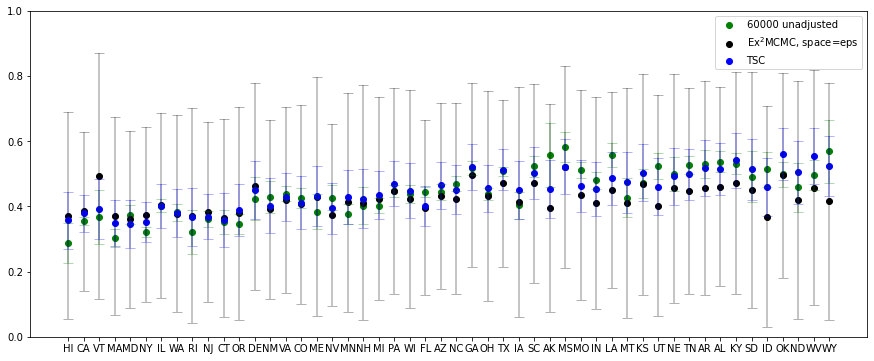

In [82]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_eps, color='black', label=r'Ex$^2$MCMC, space=eps')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_eps, 
             yerr=1.96*state_stds_pq_ex2_eps, 
             linestyle='', color='black', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_ex2_eps.png')
plt.show()

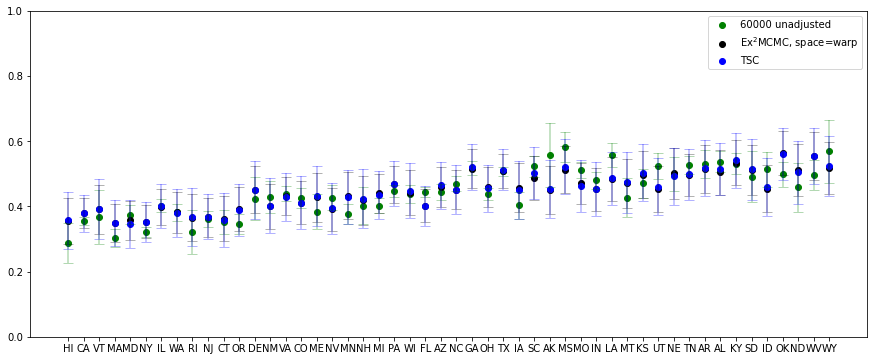

In [83]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_ex2_warp, color='black', label=r'Ex$^2$MCMC, space=warp')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_ex2_warp, 
             yerr=1.96*state_stds_pq_ex2_warp, 
             linestyle='', color='black', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_ex2_warp.png')
plt.show()

## END HERE

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
#plt.scatter(list_of_states, state_means_qp_flow, color='r', label='VI with flow')
plt.scatter(list_of_states, state_means_pq_flow, color='b', label='TSC with flow')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.0, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_qp_flow, 
#              yerr=1.96*state_stds_qp_flow, 
#              linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_flow, 
             yerr=1.96*state_stds_pq_flow, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_vi.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
#plt.scatter(list_of_states, state_means_qp, color='r', label='VI with Gaussian')
plt.scatter(list_of_states, state_means_pq, color='b', label='HSC with Gaussian')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.2, capsize=5.0)
# plt.errorbar(list_of_states, 
#              state_means_qp, 
#              yerr=1.96*state_stds_qp, 
#              linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_vi.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_pq_flow, color='r', label='HSC with Flow')
plt.scatter(list_of_states, state_means_pq, color='b', label='HSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.2, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq_flow, 
             yerr=1.96*state_stds_pq_flow, 
             linestyle='', color='r', alpha=0.7, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.7, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
state_means_mrp = []
state_stds_mrp = []
for state in list_of_states:
    idx = mrp_states_df[mrp_states_df['state'] == state].index[0]
    state_means_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate'])
    state_stds_mrp.append(mrp_states_df.loc[idx, 'mrp_estimate_se'])
state_means_mrp = np.array(state_means_mrp)
state_stds_mrp = np.array(state_stds_mrp)

In [ ]:
plt.figure(figsize=(15, 6))
plt.scatter(list_of_states, state_means_unadj_60000, color='g', label='60000 unadjusted')
plt.scatter(list_of_states, state_means_mrp, color='r', label='MRP MCMC')
plt.scatter(list_of_states, state_means_pq, color='b', label='TSC')
plt.errorbar(list_of_states, 
             state_means_unadj_60000, 
             yerr=1.96*state_stds_unadj_60000, 
             linestyle='', color='g', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_mrp, 
             yerr=1.96*state_stds_mrp, 
             linestyle='', color='r', alpha=0.3, capsize=5.0)
plt.errorbar(list_of_states, 
             state_means_pq, 
             yerr=1.96*state_stds_pq, 
             linestyle='', color='b', alpha=0.3, capsize=5.0)
plt.ylim(0, 1)
plt.legend()
plt.savefig(Path('figs') / 'survey_tsc_mrp.png')
plt.show()

In [ ]:
# print(np.sum((state_stds_pq-state_stds_mrp)**2))
# print(np.sum((state_stds_qp-state_stds_mrp)**2))

# print(np.sum((state_means_pq-state_means_mrp)**2))
# print(np.sum((state_means_qp-state_means_mrp)**2))

### Effective sample size

In [ ]:
path = 'results/survey/vi_klpq_gaussian/2021-10-13-193313/'
hmc_points_warped = np.squeeze(np.array(pd.read_pickle(path+'hmc_points.pickle')))
path = 'results/survey/vi_klpq_gaussian/2021-10-12-010955/'
hmc_points_orig = np.squeeze(np.array(pd.read_pickle(path+'hmc_points.pickle')))

In [ ]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x, axis=0)
    sigma2 = np.var(x, axis=0)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu), axis=0)
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    autocor_arr = np.zeros((n, d))
    dim_to_set_to_0 = []
    for t in range(1, n):
        autocor_arr[t-1,:] = autocor(x, t)
        if len(dim_to_set_to_0) > 0:
            autocor_arr[t-1, dim_to_set_to_0] = 0
        if t > 1:
            for d_i in range(d):
                if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                    autocor_arr[t-1, d_i] = 0
                    autocor_arr[t-2, d_i] = 0
                    if d_i not in dim_to_set_to_0:
                        dim_to_set_to_0.append(d_i)
            if len(dim_to_set_to_0) == d:
                break
    return n/(1+2*np.sum(autocor_arr, axis=0))

In [ ]:
list_of_checkpt = [1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000]
num_dim = hmc_points_warped.shape[1]
neff_list_orig = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_orig[i, :] = neff(hmc_points_orig[:idx, :])
    print(i, np.mean(neff_list_orig[i,:]/idx))

In [ ]:
neff_list_warped = np.zeros((len(list_of_checkpt), num_dim))

for i in range(len(list_of_checkpt)):
    idx = list_of_checkpt[i]
    neff_list_warped[i, :] = neff(hmc_points_warped[:idx, :])
    print(i, np.mean(neff_list_warped[i,:]/idx))

In [ ]:
np.savetxt('results/neff_list_warped.csv', neff_list_warped)
np.savetxt('results/neff_list_orig.csv', neff_list_orig)

In [ ]:
neff_list_warped = np.genfromtxt('results/neff_list_warped.csv')
neff_list_orig = np.genfromtxt('results/neff_list_orig.csv')
list_of_checkpt = [1000, 2000, 5000, 10000, 20000, 30000, 50000, 100000]

In [ ]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(list_of_checkpt, 
         np.mean(neff_list_warped, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='b',
         label='TSC')
plt.plot(list_of_checkpt, 
         np.mean(neff_list_orig, axis=1)/np.array(list_of_checkpt),
         marker='o', markersize=8, color='r',
         label='MSC')

plt.legend()
plt.ylabel('ESS/total samples')
plt.xlabel('Epoch')
plt.savefig(Path('figs') / 'survey_ess.png')

## Transform Weighted Data and Run Methods

In [ ]:
x_weighted = []
y_weighted = []
state = 0
age = 50
eth = 56
educ = 60
male_eth = 65
educ_age = 73
educ_eth = 103
for i in range(1, len(cces)+1):
    x_i = np.zeros(128)
    eth_idx = data_to_idx[cces_weighted.loc[i,'eth']]
    age_idx = data_to_idx[cces_weighted.loc[i,'age']]
    educ_idx = data_to_idx[cces_weighted.loc[i,'educ']]
    x_i[data_to_idx[cces_weighted.loc[i,'state.x']]] = 1
    x_i[age_idx] = 1
    x_i[eth_idx] = 1
    x_i[educ_idx] = 1
    
    is_male = int(cces_weighted.loc[i,'male'] + 0.5)
    male_eth_idx = male_eth + is_male * 4 + (eth_idx-eth) 
    educ_age_idx = educ_age + (educ_idx-educ) * 6 + (age_idx-age)
    educ_eth_idx = educ_eth + (educ_idx-educ) * 4 + (eth_idx-eth)
    x_i[male_eth_idx] = 1
    x_i[educ_age_idx] = 1
    x_i[educ_eth_idx] = 1
    
    x_i[123] = is_male
    x_i[124] = int(cces_weighted.loc[i,'region'] == 'South')
    x_i[125] = int(cces_weighted.loc[i,'region'] == 'North Central')
    x_i[126] = int(cces_weighted.loc[i,'region'] == 'West')
    x_i[127] = cces_weighted.loc[i,'repvote']
    
    x_weighted.append(x_i)
    y_weighted.append(cces_weighted.loc[i,'abortion'])

x_weighted = np.array(x_weighted, dtype=np.float32)
y_weighted = np.array(y_weighted, dtype=np.float32)

In [ ]:
tf.nn.sigmoid_cross_entropy_with_logits(logits=[[1.,9.],[1.,9.]], labels=[[0.,1.],[1.,0.]])


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
phi and theta are trainable by gradient methods \
\
for batch_x in x: 
   * sample alpha from q 
   * compute logpx_z = log p(y|alpha; batch_x, theta) 
   * compute logpz = log p(z; theta) 
   * compute logqz_x = log q(alpha; phi) 
   * elbo = logpx_z + logpz - logqz_x 
   * input -elbo as the objective into the autodiff. function
    
How to define q(alpha; phi):
* Gaussian with diagonal covariance
* In a separate implementation, q can also be a flow-based dist.

How to define p(alpha; theta):
* A number of Gaussian, same as in the document

How to define p(y|alpha; x, theta):
* The goal is that p(y|...) = inv_logit(alpha_1 + ... + alpha_m)
* Note that we do not want to loop over x, and decide which 
  alpha (like which state/education level) does that x_i belong to
* Map x to a multi-hot vector v, which is sparse, and element-wise 
  multiply v with alpha (like turning on and off which alpha_i is 
  relevant)


Define a variational distribution q(alpha; phi) \
Define probabilistic model p(y|alpha; x, theta) \
Define prior p(alpha; theta) \
Define HMC target p(alpha|y; theta) or p(eps|y; theta) \
phi and theta are trainable by gradient methods

for batch_x in x:

How to define p(alpha|y; theta):
* p(alpha|y; theta) is proportional to p(alpha; theta) p(y|alpha; x, theta)

In [ ]:
import pickle
import pandas as pd

In [ ]:
a = np.reshape(np.array(list(range(24))), (2,3,4))

with open('abc.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
pd.read_pickle('abc.pickle')


In [ ]:
def autocor(x, t):
    n = x.shape[0]
    mu = np.mean(x)
    sigma2 = np.var(x)
    numer = np.sum((x[:(n-t),:]-mu) * (x[t:,:]-mu))
    return numer/((n-t)*sigma2)

def neff(x):
    n = x.shape[0]
    d = x.shape[1]
    d_i = 0
    autocor_arr = np.zeros((n, d))
    for t in range(1, n):
        autocor_arr[t-1, :] = autocor(x, t)
        if t > 1:
            if autocor_arr[t-1, d_i] + autocor_arr[t-2, d_i] < 0:
                autocor_arr[t-1, d_i] = 0
                autocor_arr[t-2, d_i] = 0
                break      
    return n/(1+2*np.sum(autocor_arr))

space_btw_epochs = 1000
num_checkpt = int(hmc_points_warped.shape[0] / space_btw_epochs)
num_dim = hmc_points_warped.shape[1]
neff_list_orig = np.zeros((num_checkpt, num_dim))

for i in range(num_checkpt):
    idx = space_btw_epochs * (i+1)
    neff_list_orig[i, :] = neff(hmc_points_orig[:idx, :])
    print(i, np.mean(neff_list_orig[i,:]/idx))